## Time Series Forcast Evaluation

In [1]:
## import all the modules need to be used
import statsmodels 
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import matplotlib.pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 5

In [2]:
## load sample data  -- Thailand inflation data from 2003m1 to 2014m12
df = pd.read_csv('../data/M4_Thailand_M.csv')
df['time'] = pd.to_datetime(df.dateid01)
df.index = df['time']

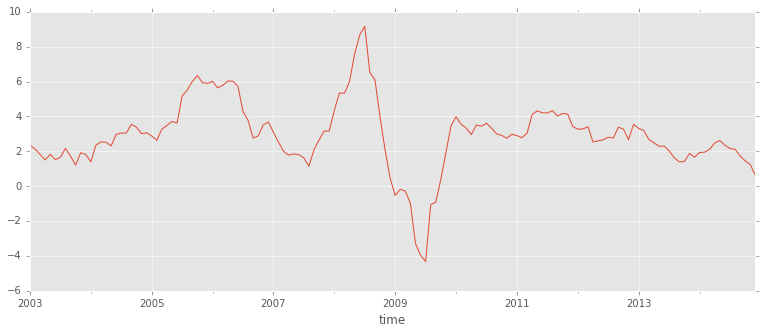

In [3]:
df.p.plot()

In [4]:
## in the model we will only use data up to 2013 m 12 and forecast the next year
y =  df.p.loc[:'2013-12-1']
arma_mod = sm.tsa.ARMA(y, order=(1,0))
arma_res = arma_mod.fit()
print arma_res.summary()

                              ARMA Model Results                              
Dep. Variable:                      p   No. Observations:                  132
Model:                     ARMA(1, 0)   Log Likelihood                -144.522
Method:                       css-mle   S.D. of innovations              0.718
Date:                Tue, 04 Oct 2016   AIC                            295.045
Time:                        16:03:52   BIC                            303.693
Sample:                    01-01-2003   HQIC                           298.559
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.8315      0.817      3.466      0.001         1.231     4.433
ar.L1.p        0.9300      0.030     31.457      0.000         0.872     0.988
                                    Roots           

/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


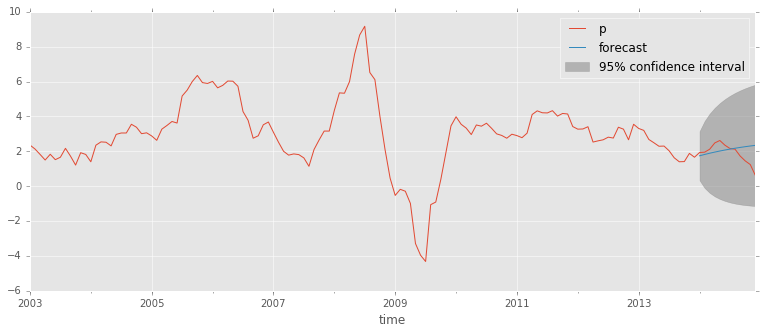

In [5]:
## let's create the fan chrat using out sample prediction 
fig, ax = plt.subplots()
ax = df.p.ix['2003-1-1':].plot(ax=ax)
fig = arma_res.plot_predict(start = '2014-1-1',end='2014-12-1', dynamic=True, ax=ax, plot_insample=False)

In [90]:
## if we just need the data rather than the chrat, we can either using forcast or predict 
## predict only give the prediction
## forecast gives, prediction, sd and confidence interval 
predict_res = arma_res.predict(start ='2014-1-1',end='2014-12-1') ## outsample forecast for next year 
forecast_res = arma_res.forecast(12)                              ## out sample forecast for the next 12 period
f_s = pd.DataFrame([forecast_res[0],forecast_res[1],forecast_res[2]]).T
f_s.columns = ['prediction','sd','CI']
f_s.head()

,prediction,sd,CI
0,1.74198,0.717734,"[0.335249728247, 3.14871552405]"
1,1.81823,0.980158,"[-0.102845634866, 3.73930208801]"
2,1.88914,1.16021,"[-0.384840519733, 4.16311705981]"
3,1.95509,1.29593,"[-0.584891015689, 4.49506327792]"
4,2.01642,1.40277,"[-0.732952365175, 4.7657904775]"


In [91]:
p_y = df.p.loc['2014-1-1':'2014-12-1']
future = pd.DataFrame({'y':p_y.values,'y_hat':predict_res.values},index=p_y.index)
y_last =  df.p.loc['2013-12-1']
future['naive'] = [y_last]*12

## calculate RMSE, BIAS , U1, U2
fe_n = future.naive - future.y
RMSE_n = np.sqrt(fe_n.dot(fe_n)/12)
fe = future.y_hat-future.y
RMSE = np.sqrt(fe.dot(fe)/12)
BIAS = fe.mean()
MAE = np.abs(fe).mean()
MAPE = np.abs(fe/future.y).mean()
U1 = RMSE/(np.sqrt((future.y_hat**2).mean())+np.sqrt((future.y**2).mean()))
U2 = RMSE/RMSE_n 

#### All these evaluations statistics need to be rewrite into functions later

## Forecast Strategy: Expanding Window or Rolling Window

When we do forecase over 1 period ahead, we need to think about our forecasting startegy. We would like to keep our forecasting horizon consistant. There are basically two statrgies: Expanding window or Rolling window.

Basically, all params will be reestimated when new data points are predicted.  

In [92]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='pic/expanding.PNG'></td><td><img src='pic/rolling.PNG'></td></tr></table>"))

,


In [359]:
#####################################################
#### create a function for expanding window strategy
#####################################################
# for this function, the forecast horizon is 1 period ahead, 
# the function is a bit differnt from the eview program. 

def forecast_strategy(y=[],strategy_rolling=0,n_step_forecast=3,window=24,t_last='2012-12-01'):
    frequency = pd.infer_freq(y.index)
    y_hat = y[:t_last]
    forecast_period = pd.Series(np.zeros(n_step_forecast),index=pd.date_range(t_last, freq = frequency, periods = n_step_forecast+1)[1:])
    y_hat = y_hat.append(forecast_period)

    for i in range(n_step_forecast):
        end = y_hat.index.get_loc(t_last)
        if strategy_rolling == 0 :
            y_w = y_hat[:end+i+1]
        else:
            y_w = y_hat[end+i+1-window:end+i+1]
        
        ######## here is where the model get defined #####
        arma_mod = sm.tsa.ARMA(y_w, order=(1,0))
        ##################################################
        
        arma_res = arma_mod.fit()
        y_hat[end+i+1] = arma_res.forecast(1)[0][0]

    y.name = 'y'
    y_hat.name = 'y_hat'
    results = pd.concat([y, y_hat], axis=1).dropna()
    return results

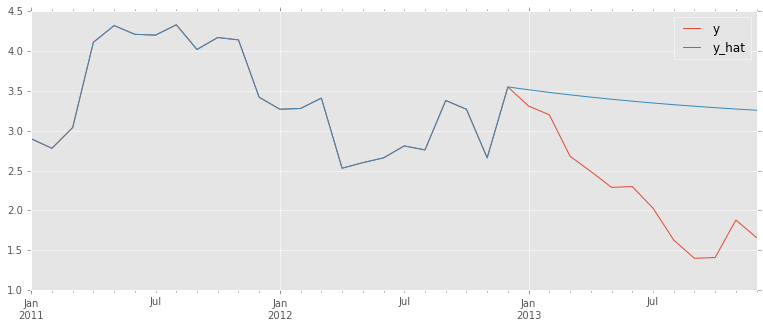

In [360]:
### expanding forcast strategy ###
results = forecast_strategy(df.p,strategy_rolling=0,n_step_forecast=12,t_last='2012-12-01')
results['2011':].plot()

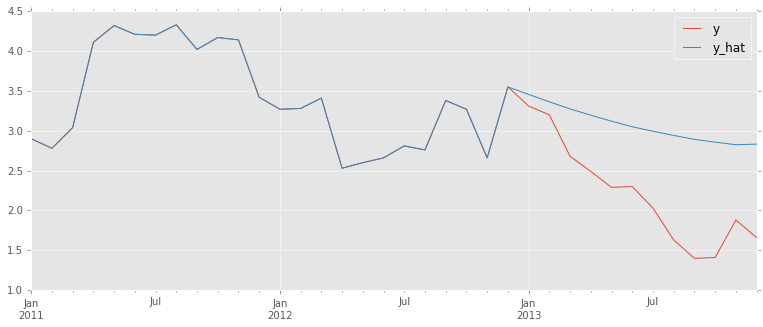

In [361]:
### rolling forcast strategy ###
results = forecast_strategy(df.p,strategy_rolling=1,n_step_forecast=12,window=50,t_last='2012-12-01')
results['2011':].plot()

### The data seems to have a structural break, so both estimation are poor. But we can see that when there is a structural break, rolling window extimation seems to perfrom better then expanding window

## How to create a fan chart in python

Plese not that, in the stats model, error term is assumed to be normal. it is not using boot strap method. I need to look into it to see how to make bootstrap work. 

In [74]:
## First, forecast the model 
y =  df.p.loc[:'2013-12-1']
arma_mod = sm.tsa.ARMA(y, order=(1,0))
arma_res = arma_mod.fit()
## make a list of leves of confidence interval you want to show
alpha = [0.9,0.6,0.3,0.05]

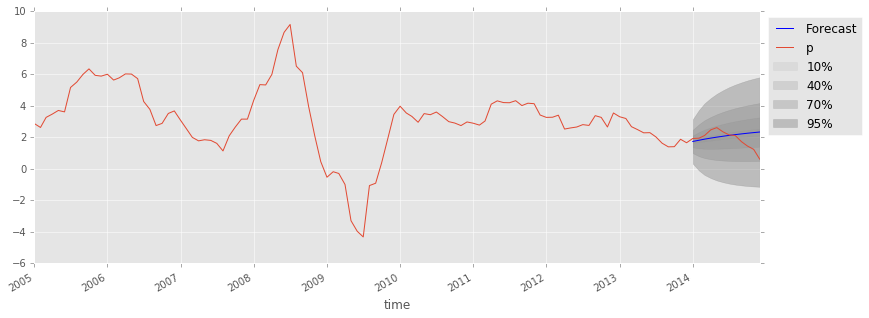

In [88]:
## make the charts 
rng = pd.date_range('2013-12-1', periods = 13, freq = 'MS')[1:]
fig,ax = plt.subplots()
for i,val in enumerate(alpha):
    op = 0.4*(i+1)/len(alpha)
    confi = arma_res.forecast(12,alpha = alpha[i])[2]
    confi_high = confi[:,0]
    confi_low = confi[:,1]
    label = "{0:.0%}".format(1 -alpha[i])
    ax.fill_between(rng,confi_high,confi_low,color='grey',alpha = op,label=label)
ax.plot(rng,arma_res.forecast(12)[0],color = 'blue',label='Forecast')
ax = df.p.ix['2005-1-1':'2014-12-1'].plot(ax=ax)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))      ## positoin the legend 
plt.show()